# Student-to-Module Recommender System

Dit notebook implementeert een **student-naar-module recommender systeem** voor de VKM dataset. 

## Doel
Het systeem helpt studenten om modules te vinden die passen bij hun interesses en doelen.

## Hoe het werkt
1. **Student vult een profiel in** (tekst over hun interesses, bijvoorbeeld: "Ik ben geïnteresseerd in psychologie, coaching en zorg")
2. **Systeem vectoriseert het profiel** met dezelfde TF-IDF vectorizer als de modules
3. **Cosine similarity berekenen** tussen student profiel en alle modules
4. **Top 3-5 aanbevelingen** tonen met uitleg waarom deze modules passen

Dit is **GEEN** module-naar-module vergelijking, maar een echte student coach!

In [3]:
# Import benodigde libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import load_npz
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(" Libraries succesvol geladen!")
print(" Klaar voor student-to-module recommendations")

 Libraries succesvol geladen!
 Klaar voor student-to-module recommendations


## Data en Modellen Laden

We laden:
1. De **dataset** met module informatie
2. De **TF-IDF matrix** (alle modules gevectoriseerd)
3. De **fitted TF-IDF vectorizer** (om student profielen te vectoriseren)

In [4]:
# Laad de dataset
df = pd.read_csv('Uitgebreide_VKM_dataset_cleaned.csv')

print(f" Dataset geladen")
print(f"  Aantal modules: {len(df)}")
print(f"\nModule overzicht:")
print(df[['id', 'name', 'shortdescription', 'level', 'studycredit']].head(3))

 Dataset geladen
  Aantal modules: 211

Module overzicht:
    id                          name  \
0  159  Kennismaking met Psychologie   
1  160   Learning and working abroad   
2  161       Proactieve zorgplanning   

                                    shortdescription  level  studycredit  
0  Brein, gedragsbeinvloeding, ontwikkelingspsych...  NLQF5           15  
1  Internationaal, persoonlijke ontwikkeling, ver...  NLQF5           15  
2     Proactieve zorgplanning, cocreatie, ziekenhuis  NLQF5           15  


In [5]:
# Laad TF-IDF matrix en vectorizer
print("Laden van TF-IDF componenten...")

# Laad de sparse TF-IDF matrix
tfidf_matrix = load_npz('tfidf_matrix.npz')
print(f" TF-IDF matrix geladen: {tfidf_matrix.shape}")

# Laad de fitted vectorizer (belangrijk voor student profielen!)
with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
print(f" TF-IDF vectorizer geladen")
print(f"  Configuratie: {vectorizer.ngram_range} n-grams")
print(f"  Max features: {vectorizer.max_features}")
print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")

print("\n Alle componenten succesvol geladen!")

Laden van TF-IDF componenten...
 TF-IDF matrix geladen: (211, 2552)
 TF-IDF vectorizer geladen
  Configuratie: (1, 2) n-grams
  Max features: 6000
  Vocabulary size: 2552

 Alle componenten succesvol geladen!


## Student-to-Module Recommender Class

Deze class implementeert het **student-naar-module recommender systeem**.

### Hoofdfunctionaliteiten:
1. **`get_recommendations_for_student(profile_text)`** - Aanbevelingen op basis van student profiel
2. **`explain_recommendation()`** - Uitleg waarom een module past bij de student
3. **`compare_students()`** - Vergelijk verschillende student profielen

In [6]:
class StudentModuleRecommender:
    """
    Student-to-Module Recommender System (Smart Study Coach).
    
    Dit systeem helpt studenten om modules te vinden die passen bij hun
    interesses en doelen op basis van TF-IDF vectorization en cosine similarity.
    """
    
    def __init__(self, df, tfidf_matrix, vectorizer):
        """
        Initialiseer de recommender.
        
        Parameters:
        - df: DataFrame met module informatie
        - tfidf_matrix: TF-IDF matrix van alle modules
        - vectorizer: Fitted TF-IDF vectorizer
        """
        self.df = df.copy()
        self.tfidf_matrix = tfidf_matrix
        self.vectorizer = vectorizer
        
        print(f" Student-Module Recommender geïnitialiseerd")
        print(f"  {len(df)} modules beschikbaar")
        print(f"  {tfidf_matrix.shape[1]} features")
    
    def get_recommendations_for_student(self, student_profile, n_recommendations=5, 
                                       min_similarity=0.0, level_filter=None):
        """
        Krijg module aanbevelingen voor een student profiel.
        
        Parameters:
        - student_profile: Tekst beschrijving van student interesses (bijv. "Ik ben geïnteresseerd in psychologie en zorg")
        - n_recommendations: Aantal aanbevelingen
        - min_similarity: Minimale similarity score
        - level_filter: Filter op niveau (bijv. 'NLQF5' of ['NLQF5', 'NLQF6'])
        
        Returns:
        - DataFrame met aanbevolen modules en similarity scores
        """
        # Vectoriseer het student profiel met dezelfde vectorizer
        student_vector = self.vectorizer.transform([student_profile])
        
        # Bereken cosine similarity tussen student en alle modules
        similarities = cosine_similarity(student_vector, self.tfidf_matrix)[0]
        
        # Maak DataFrame met resultaten
        results_df = self.df.copy()
        results_df['similarity_score'] = similarities
        
        # Filter op minimum similarity
        results_df = results_df[results_df['similarity_score'] >= min_similarity]
        
        # Filter op level indien opgegeven
        if level_filter is not None:
            if isinstance(level_filter, str):
                level_filter = [level_filter]
            results_df = results_df[results_df['level'].isin(level_filter)]
        
        # Sorteer op similarity (hoogste eerst)
        results_df = results_df.sort_values('similarity_score', ascending=False)
        
        # Selecteer top N
        top_results = results_df.head(n_recommendations)
        
        # Selecteer relevante kolommen
        columns = ['id', 'name', 'shortdescription', 'level', 'studycredit', 
                  'location', 'similarity_score']
        available_columns = [col for col in columns if col in top_results.columns]
        
        return top_results[available_columns]
    
    def explain_recommendation(self, student_profile, module_id, top_n_features=10):
        """
        Leg uit waarom een module past bij een student profiel.
        
        Toont de top features die het meest bijdragen aan de similarity.
        """
        # Vectoriseer student profiel
        student_vector = self.vectorizer.transform([student_profile])
        
        # Vind module index
        module_idx = self.df[self.df['id'] == module_id].index
        if len(module_idx) == 0:
            return f"Module {module_id} niet gevonden"
        module_idx = module_idx[0]
        
        # Haal module informatie op
        module = self.df.iloc[module_idx]
        module_vector = self.tfidf_matrix[module_idx]
        
        # Bereken similarity
        similarity = cosine_similarity(student_vector, module_vector)[0][0]
        
        # Vind belangrijkste features
        student_dense = student_vector.toarray()[0]
        module_dense = module_vector.toarray()[0]
        
        # Element-wise product geeft contribution van elke feature
        feature_contributions = student_dense * module_dense
        
        # Sorteer features op contribution
        top_indices = feature_contributions.argsort()[-top_n_features:][::-1]
        feature_names = self.vectorizer.get_feature_names_out()
        
        # Print uitleg
        print("=" * 80)
        print(f"WAAROM PAST '{module['name']}' BIJ DIT STUDENT PROFIEL?")
        print("=" * 80)
        print(f"\nOverall Similarity Score: {similarity:.4f}")
        print(f"\nModule Details:")
        print(f"   Naam: {module['name']}")
        print(f"   Level: {module['level']} | Credits: {module['studycredit']}")
        print(f"   Beschrijving: {module['shortdescription'][:200]}...")
        
        print(f"\nTop {top_n_features} Matching Features (woorden/concepten):")
        print("-" * 80)
        
        for i, idx in enumerate(top_indices, 1):
            if feature_contributions[idx] > 0:
                feature = feature_names[idx]
                student_weight = student_dense[idx]
                module_weight = module_dense[idx]
                contribution = feature_contributions[idx]
                
                print(f"{i:2d}. '{feature}'")
                print(f"    → In jouw profiel: {student_weight:.4f}")
                print(f"    → In deze module: {module_weight:.4f}")
                print(f"    → Contribution: {contribution:.4f}")
        
        print("\n" + "=" * 80)
        print("Interpretatie:")
        print("Hoe hoger de contribution, hoe sterker dit woord/concept voorkomt")
        print("in zowel jouw profiel als in de module beschrijving.")
        print("=" * 80)
    
    def compare_student_profiles(self, profiles_dict, n_recommendations=3):
        """
        Vergelijk aanbevelingen voor verschillende student profielen.
        
        Parameters:
        - profiles_dict: Dictionary met {naam: profiel_tekst}
        - n_recommendations: Aantal aanbevelingen per profiel
        """
        print("=" * 80)
        print("VERGELIJKING VAN STUDENT PROFIELEN")
        print("=" * 80)
        
        for student_name, profile in profiles_dict.items():
            print(f"\n{'='*80}")
            print(f"Student: {student_name}")
            print(f"Profiel: {profile[:100]}...")
            print(f"{'='*80}")
            
            recs = self.get_recommendations_for_student(profile, n_recommendations=n_recommendations)
            
            for i, (idx, row) in enumerate(recs.iterrows(), 1):
                print(f"\n{i}. {row['name']} (similarity: {row['similarity_score']:.4f})")
                print(f"   {row['shortdescription'][:120]}...")
    
    def get_statistics(self):
        """
        Toon statistieken over de TF-IDF representatie.
        """
        print("=" * 60)
        print("RECOMMENDER STATISTIEKEN")
        print("=" * 60)
        print(f"Aantal modules: {len(self.df)}")
        print(f"Aantal features: {self.tfidf_matrix.shape[1]}")
        print(f"Sparsity: {(1 - self.tfidf_matrix.nnz / (self.tfidf_matrix.shape[0] * self.tfidf_matrix.shape[1])) * 100:.2f}%")
        print(f"N-gram range: {self.vectorizer.ngram_range}")
        
        # Module level distributie
        print(f"\nModule distributie per level:")
        level_counts = self.df['level'].value_counts()
        for level, count in level_counts.items():
            print(f"  {level}: {count} modules")

print("StudentModuleRecommender class gedefinieerd")

StudentModuleRecommender class gedefinieerd


## Initialiseer Recommender

Nu maken we de recommender aan en tonen wat statistieken.

In [7]:
# Initialiseer de Student-Module Recommender
recommender = StudentModuleRecommender(df, tfidf_matrix, vectorizer)

# Toon statistieken
recommender.get_statistics()

 Student-Module Recommender geïnitialiseerd
  211 modules beschikbaar
  2552 features
RECOMMENDER STATISTIEKEN
Aantal modules: 211
Aantal features: 2552
Sparsity: 97.90%
N-gram range: (1, 2)

Module distributie per level:
  NLQF6: 114 modules
  NLQF5: 97 modules


## Voorbeeld 1: Student Profiel - Interesse in Psychologie en Zorg

Laten we een student profiel maken en kijken welke modules worden aanbevolen.

In [8]:
# Student profiel 1: Interesse in psychologie en zorg
student_profile_1 = """
Ik ben geïnteresseerd in psychologie, coaching en zorg. 
Ik wil graag leren over menselijk gedrag, ontwikkelingspsychologie en hoe ik mensen kan helpen.
Ook ben ik nieuwsgierig naar gespreksvoering en het begeleiden van anderen.
"""

print("=" * 80)
print("STUDENT PROFIEL")
print("=" * 80)
print(student_profile_1)
print("\n" + "=" * 80)
print("TOP 5 AANBEVOLEN MODULES")
print("=" * 80)

# Krijg aanbevelingen
recommendations = recommender.get_recommendations_for_student(
    student_profile_1,
    n_recommendations=5
)

# Toon resultaten
for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
    print(f"\n{i}. {row['name']}")
    print(f"   Similarity Score: {row['similarity_score']:.4f}")
    print(f"   {row['level']} | {row['studycredit']} credits | {row['location']}")
    print(f"   {row['shortdescription'][:150]}...")

STUDENT PROFIEL

Ik ben geïnteresseerd in psychologie, coaching en zorg. 
Ik wil graag leren over menselijk gedrag, ontwikkelingspsychologie en hoe ik mensen kan helpen.
Ook ben ik nieuwsgierig naar gespreksvoering en het begeleiden van anderen.


TOP 5 AANBEVOLEN MODULES

1. Kennismaking met Psychologie
   Similarity Score: 0.2169
   NLQF5 | 15 credits | Den Bosch
   Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen....

2. Organizational Behavior (samenwerking HRM - IVK)
   Similarity Score: 0.1727
   NLQF5 | 30 credits | Breda
   organisatiegedrag, groepsdynamica, verandermanagement, organisatiecultuur, leiderschap...

3. Veranderen is Mensenwerk 
   Similarity Score: 0.1243
   NLQF6 | 30 credits | Den Bosch
   oud model van economische groei ...

4. minor Forensisch Onderzoek in de Rechtbank- (IF/KA)
   Similarity Score: 0.1177
   NLQF6 | 30 credits | Breda en Den Bosch
   strafrecht, forensisch, bewijs, psychologie, criminologie...

5. Inn

In [9]:
# Leg uit waarom de top aanbeveling past bij dit profiel
top_module_id = recommendations.iloc[0]['id']

recommender.explain_recommendation(
    student_profile_1,
    top_module_id,
    top_n_features=8
)

WAAROM PAST 'Kennismaking met Psychologie' BIJ DIT STUDENT PROFIEL?

Overall Similarity Score: 0.2169

Module Details:
   Naam: Kennismaking met Psychologie
   Level: NLQF5 | Credits: 15
   Beschrijving: Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen....

Top 8 Matching Features (woorden/concepten):
--------------------------------------------------------------------------------
 1. 'psychologie'
    → In jouw profiel: 0.3652
    → In deze module: 0.2499
    → Contribution: 0.0913
 2. 'gedrag'
    → In jouw profiel: 0.3277
    → In deze module: 0.2243
    → Contribution: 0.0735
 3. 'anderen'
    → In jouw profiel: 0.3277
    → In deze module: 0.1592
    → Contribution: 0.0522

Interpretatie:
Hoe hoger de contribution, hoe sterker dit woord/concept voorkomt
in zowel jouw profiel als in de module beschrijving.


## Voorbeeld 2: Student Profiel - Internationale Zorg en Verpleegkunde

Een ander student profiel met andere interesses.

In [10]:
# Student profiel 2: Internationale zorg
student_profile_2 = """
Ik wil graag internationaal werken in de zorg. Stage lopen in het buitenland lijkt me geweldig.
Ik ben geïnteresseerd in verpleegkunde en wil mijn persoonlijke ontwikkeling stimuleren 
door ervaring op te doen in een internationale context.
"""

print("=" * 80)
print("STUDENT PROFIEL 2")
print("=" * 80)
print(student_profile_2)
print("\n" + "=" * 80)
print("TOP 5 AANBEVOLEN MODULES")
print("=" * 80)

recommendations_2 = recommender.get_recommendations_for_student(
    student_profile_2,
    n_recommendations=5
)

for i, (idx, row) in enumerate(recommendations_2.iterrows(), 1):
    print(f"\n{i}. {row['name']}")
    print(f"   Similarity Score: {row['similarity_score']:.4f}")
    print(f"   {row['level']} | {row['studycredit']} credits | {row['location']}")
    print(f"   {row['shortdescription'][:150]}...")

STUDENT PROFIEL 2

Ik wil graag internationaal werken in de zorg. Stage lopen in het buitenland lijkt me geweldig.
Ik ben geïnteresseerd in verpleegkunde en wil mijn persoonlijke ontwikkeling stimuleren 
door ervaring op te doen in een internationale context.


TOP 5 AANBEVOLEN MODULES

1. Learning and working abroad
   Similarity Score: 0.5850
   NLQF5 | 15 credits | Den Bosch
   Internationaal, persoonlijke ontwikkeling, verpleegkunde...

2. Teaching English Abroad
   Similarity Score: 0.2729
   NLQF6 | 30 credits | Breda
   Nog niet bepaald...

3. Going global: internationaal perspectief op je toekomst
   Similarity Score: 0.2221
   NLQF5 | 15 credits | Breda en Den Bosch
   Globalisering, interculturele communicatie, gezondheid, welzijn, verdieping interculturele competenties...

4. Studeren buitenland
   Similarity Score: 0.2105
   NLQF6 | 30 credits | Breda
   Internationalisering, ervaring buitenland, SDG's...

5. Proactieve zorgplanning
   Similarity Score: 0.0991
   NLQF5 | 15

In [21]:
# Leg uit waarom de top aanbeveling past bij dit profiel
top_module_id = recommendations_2.iloc[0]['id']

recommender.explain_recommendation(
    student_profile_2,
    top_module_id,
    top_n_features=8
)

WAAROM PAST 'Learning and working abroad' BIJ DIT STUDENT PROFIEL?

Overall Similarity Score: 0.5850

Module Details:
   Naam: Learning and working abroad
   Level: NLQF5 | Credits: 15
   Beschrijving: Internationaal, persoonlijke ontwikkeling, verpleegkunde...

Top 8 Matching Features (woorden/concepten):
--------------------------------------------------------------------------------
 1. 'stage'
    → In jouw profiel: 0.2558
    → In deze module: 0.2667
    → Contribution: 0.0682
 2. 'internationale'
    → In jouw profiel: 0.2753
    → In deze module: 0.2427
    → Contribution: 0.0668
 3. 'verpleegkunde'
    → In jouw profiel: 0.2558
    → In deze module: 0.2107
    → Contribution: 0.0539
 4. 'stage lopen'
    → In jouw profiel: 0.3049
    → In deze module: 0.1630
    → Contribution: 0.0497
 5. 'internationale context'
    → In jouw profiel: 0.3049
    → In deze module: 0.1630
    → Contribution: 0.0497
 6. 'lopen'
    → In jouw profiel: 0.2882
    → In deze module: 0.1541
    → Cont

## Voorbeeld 3: Student Profiel - Palliatieve Zorg en Rouw

Nog een ander profiel met specifieke interesse in rouw en verlies.

In [12]:
# Student profiel 3: Palliatieve zorg en rouw
student_profile_3 = """
Ik wil graag werken met mensen die rouw en verlies ervaren. 
Palliatieve zorg spreekt me aan en ik wil leren over oncologie en 
hoe ik mensen kan begeleiden in moeilijke tijden. Ook culturele diversiteit vind ik belangrijk.
"""

print("=" * 80)
print("STUDENT PROFIEL 3")
print("=" * 80)
print(student_profile_3)
print("\n" + "=" * 80)
print("TOP 5 AANBEVOLEN MODULES")
print("=" * 80)

recommendations_3 = recommender.get_recommendations_for_student(
    student_profile_3,
    n_recommendations=5
)

for i, (idx, row) in enumerate(recommendations_3.iterrows(), 1):
    print(f"\n{i}. {row['name']}")
    print(f"   Similarity Score: {row['similarity_score']:.4f}")
    print(f"   {row['level']} | {row['studycredit']} credits | {row['location']}")
    print(f"   {row['shortdescription'][:150]}...")
    
# Uitleg voor top match
print("\n\n")
top_module_id_3 = recommendations_3.iloc[0]['id']
recommender.explain_recommendation(student_profile_3, top_module_id_3, top_n_features=6)

STUDENT PROFIEL 3

Ik wil graag werken met mensen die rouw en verlies ervaren. 
Palliatieve zorg spreekt me aan en ik wil leren over oncologie en 
hoe ik mensen kan begeleiden in moeilijke tijden. Ook culturele diversiteit vind ik belangrijk.


TOP 5 AANBEVOLEN MODULES

1. Rouw en verlies
   Similarity Score: 0.2894
   NLQF6 | 30 credits | Den Bosch
   Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit...

2. Palliatieve zorg
   Similarity Score: 0.2302
   NLQF6 | 30 credits | Breda
   Nog niet bepaald...

3. Zorg dichtbij
   Similarity Score: 0.1310
   NLQF5 | 15 credits | Breda
   Zorg op afstand, technologie, implementeren, zorg, veranderkunde...

4. Zorg in de langdurige hulpverlening
   Similarity Score: 0.1171
   NLQF5 | 15 credits | Breda en Den Bosch
   Hulpverlening, zorg, psychische problematiek, verslaving...

5. Langer thuis in de wijk
   Similarity Score: 0.1110
   NLQF5 | 15 credits | Breda
   wijkgericht werken, eigen regie, zorg, welzijn, oudere

In [22]:
# Leg uit waarom de top aanbeveling past bij dit profiel
top_module_id = recommendations_3.iloc[0]['id']

recommender.explain_recommendation(
    student_profile_3,
    top_module_id,
    top_n_features=8
)

WAAROM PAST 'Rouw en verlies' BIJ DIT STUDENT PROFIEL?

Overall Similarity Score: 0.2894

Module Details:
   Naam: Rouw en verlies
   Level: NLQF6 | Credits: 30
   Beschrijving: Rouw & verlies, palliatieve zorg & redeneren, trauma, culturele diversiteit...

Top 8 Matching Features (woorden/concepten):
--------------------------------------------------------------------------------
 1. 'palliatieve'
    → In jouw profiel: 0.3138
    → In deze module: 0.2321
    → Contribution: 0.0728
 2. 'oncologie'
    → In jouw profiel: 0.3138
    → In deze module: 0.2321
    → Contribution: 0.0728
 3. 'palliatieve zorg'
    → In jouw profiel: 0.3138
    → In deze module: 0.1745
    → Contribution: 0.0548
 4. 'diversiteit'
    → In jouw profiel: 0.2966
    → In deze module: 0.0786
    → Contribution: 0.0233
 5. 'culturele'
    → In jouw profiel: 0.2966
    → In deze module: 0.0786
    → Contribution: 0.0233
 6. 'begeleiden'
    → In jouw profiel: 0.2833
    → In deze module: 0.0751
    → Contribution:

## Vergelijking van Student Profielen

Laten we de drie student profielen vergelijken en zien hoe de aanbevelingen verschillen.

In [13]:
# Vergelijk de drie student profielen
student_profiles = {
    "Student A (Psychologie & Coaching)": student_profile_1,
    "Student B (Internationale Zorg)": student_profile_2,
    "Student C (Palliatieve Zorg & Rouw)": student_profile_3
}

recommender.compare_student_profiles(student_profiles, n_recommendations=3)

VERGELIJKING VAN STUDENT PROFIELEN

Student: Student A (Psychologie & Coaching)
Profiel: 
Ik ben geïnteresseerd in psychologie, coaching en zorg. 
Ik wil graag leren over menselijk gedrag, ...

1. Kennismaking met Psychologie (similarity: 0.2169)
   Brein, gedragsbeinvloeding, ontwikkelingspsychologie, gespreksvoering en ontwikkelingsfasen....

2. Organizational Behavior (samenwerking HRM - IVK) (similarity: 0.1727)
   organisatiegedrag, groepsdynamica, verandermanagement, organisatiecultuur, leiderschap...

3. Veranderen is Mensenwerk  (similarity: 0.1243)
   oud model van economische groei ...

Student: Student B (Internationale Zorg)
Profiel: 
Ik wil graag internationaal werken in de zorg. Stage lopen in het buitenland lijkt me geweldig.
Ik ...

1. Learning and working abroad (similarity: 0.5850)
   Internationaal, persoonlijke ontwikkeling, verpleegkunde...

2. Teaching English Abroad (similarity: 0.2729)
   Nog niet bepaald...

3. Going global: internationaal perspectief op je toe

## Visualisatie: Similarity Scores Verdeling

Bekijk hoe de similarity scores zich verdelen voor verschillende student profielen.

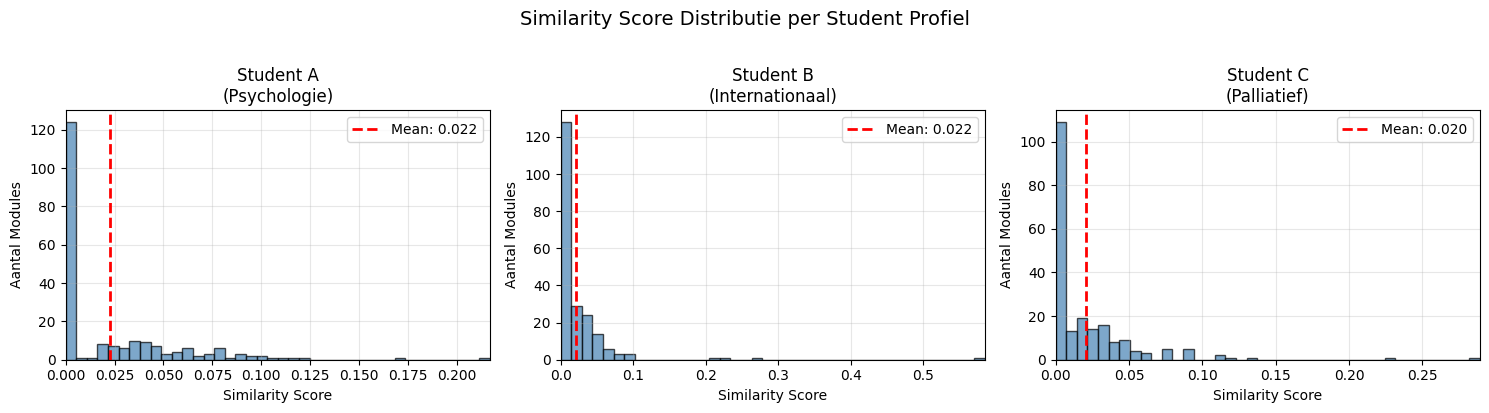


💡 Interpretatie:
- Hoe hoger de similarity score, hoe beter de module past bij het student profiel
- Een meer specifiek profiel (met unieke woorden) geeft een smallere distributie
- Een algemeen profiel geeft een bredere distributie


In [14]:
# Visualiseer similarity scores voor alle drie de profielen
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

profiles_list = [
    ("Student A\n(Psychologie)", student_profile_1),
    ("Student B\n(Internationaal)", student_profile_2),
    ("Student C\n(Palliatief)", student_profile_3)
]

for idx, (name, profile) in enumerate(profiles_list):
    # Bereken similarities voor alle modules
    student_vector = vectorizer.transform([profile])
    similarities = cosine_similarity(student_vector, tfidf_matrix)[0]
    
    # Plot histogram
    axes[idx].hist(similarities, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(similarities.mean(), color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {similarities.mean():.3f}')
    axes[idx].set_xlabel('Similarity Score')
    axes[idx].set_ylabel('Aantal Modules')
    axes[idx].set_title(name)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(0, max(similarities))

plt.suptitle('Similarity Score Distributie per Student Profiel', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Interpretatie:")
print("- Hoe hoger de similarity score, hoe beter de module past bij het student profiel")
print("- Een meer specifiek profiel (met unieke woorden) geeft een smallere distributie")
print("- Een algemeen profiel geeft een bredere distributie")

## Visualisatie: Top Modules per Student

Vergelijk de top 5 modules voor elk student profiel visueel.

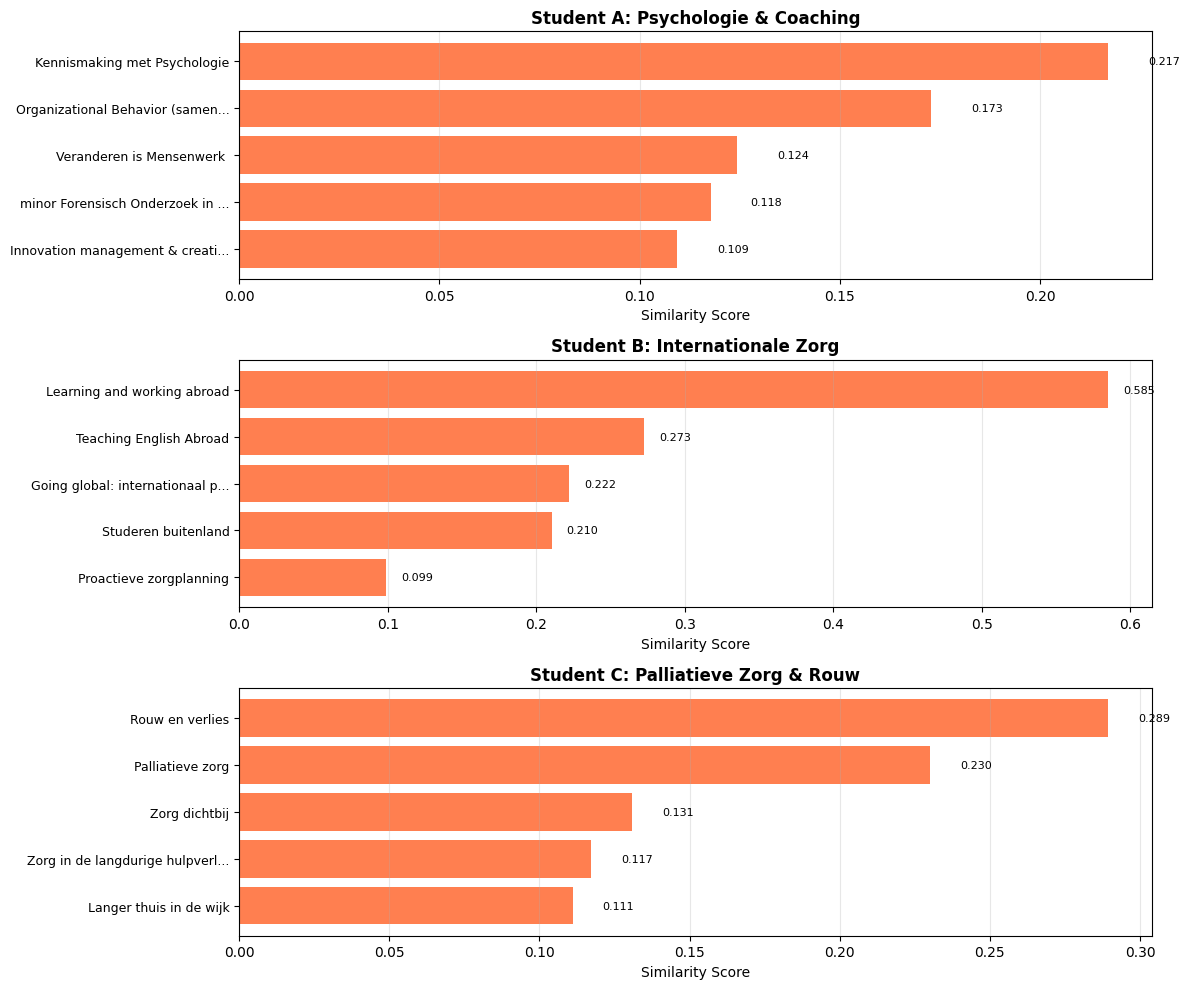


Observaties:
- Elk student profiel krijgt unieke aanbevelingen
- De similarity scores weerspiegelen de match tussen student en module
- Specifiekere profielen geven vaak hogere similarity scores voor de beste matches


In [15]:
# Vergelijk top 5 modules voor elk profiel visueel
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

profiles_with_names = [
    ("Student A: Psychologie & Coaching", student_profile_1),
    ("Student B: Internationale Zorg", student_profile_2),
    ("Student C: Palliatieve Zorg & Rouw", student_profile_3)
]

for idx, (name, profile) in enumerate(profiles_with_names):
    recs = recommender.get_recommendations_for_student(profile, n_recommendations=5)
    
    # Maak labels (shorten names)
    labels = [name[:30] + '...' if len(name) > 30 else name for name in recs['name']]
    scores = recs['similarity_score'].values
    
    # Plot horizontal bar chart
    axes[idx].barh(range(len(labels)), scores, color='coral')
    axes[idx].set_yticks(range(len(labels)))
    axes[idx].set_yticklabels(labels, fontsize=9)
    axes[idx].set_xlabel('Similarity Score')
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (label, score) in enumerate(zip(labels, scores)):
        axes[idx].text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nObservaties:")
print("- Elk student profiel krijgt unieke aanbevelingen")
print("- De similarity scores weerspiegelen de match tussen student en module")
print("- Specifiekere profielen geven vaak hogere similarity scores voor de beste matches")

## Interactieve Functie: Vraag Jouw Aanbevelingen!

Gebruik deze eenvoudige functie om snel aanbevelingen te krijgen voor een student profiel.

In [16]:
def get_my_recommendations(student_profile, n=5, level=None, show_explanation=True):
    """
    Eenvoudige wrapper functie om snel aanbevelingen te krijgen.
    
    Parameters:
    - student_profile: Jouw interesses als tekst (bijv. "Ik ben geïnteresseerd in...")
    - n: Aantal aanbevelingen (default 5)
    - level: Filter op niveau, bijv. 'NLQF5' (optioneel)
    - show_explanation: Toon uitleg voor top match (default True)
    
    Voorbeeld:
        get_my_recommendations("Ik wil graag leren over ICT en programmeren", n=3)
    """
    print("=" * 80)
    print("JOUW STUDENT PROFIEL")
    print("=" * 80)
    print(student_profile)
    print("\n" + "=" * 80)
    print(f"TOP {n} AANBEVOLEN MODULES VOOR JOU")
    print("=" * 80)
    
    # Get recommendations
    recs = recommender.get_recommendations_for_student(
        student_profile,
        n_recommendations=n,
        level_filter=level
    )
    
    if len(recs) == 0:
        print("\nGeen modules gevonden die passen bij jouw profiel.")
        print("Probeer een ander profiel of verwijder level filter.")
        return
    
    # Display results
    for i, (idx, row) in enumerate(recs.iterrows(), 1):
        print(f"\n{i}. {row['name']}")
        print(f"   Match Score: {row['similarity_score']:.4f}")
        print(f"   {row['level']} | {row['studycredit']} credits |  {row['location']}")
        print(f"   {row['shortdescription'][:150]}...")
    
    # Show explanation for top match
    if show_explanation and len(recs) > 0:
        print("\n\n")
        top_module_id = recs.iloc[0]['id']
        recommender.explain_recommendation(student_profile, top_module_id, top_n_features=6)
    
    return recs

print("Functie 'get_my_recommendations' klaar voor gebruik!")
print("\nGebruik:")
print('  get_my_recommendations("Ik ben geïnteresseerd in...", n=5)')

Functie 'get_my_recommendations' klaar voor gebruik!

Gebruik:
  get_my_recommendations("Ik ben geïnteresseerd in...", n=5)


In [17]:
# Test de interactieve functie met een nieuw profiel
my_profile = """
Ik wil meer leren over data science.
"""

get_my_recommendations(my_profile, n=3, show_explanation=True)

JOUW STUDENT PROFIEL

Ik wil meer leren over data science.


TOP 3 AANBEVOLEN MODULES VOOR JOU

1. Datagedreven besluitvorming met AI 
   Match Score: 0.3385
   NLQF6 | 15 credits |  Breda
   Data science, AI, Python, onderzoek...

2. Forensische Chemie
   Match Score: 0.2702
   NLQF6 | 15 credits |  Breda en Den Bosch
   chemische analyse, data analyse, forensic science, ontwikkelen en innoveren...

3. Bioinformatica
   Match Score: 0.2116
   NLQF5 | 15 credits |  Breda
   Bioinformatics is a combination of life science and informatics. It always involves programming and data handling, knowledge of Linux besides Windows,...



WAAROM PAST 'Datagedreven besluitvorming met AI ' BIJ DIT STUDENT PROFIEL?

Overall Similarity Score: 0.3385

Module Details:
   Naam: Datagedreven besluitvorming met AI 
   Level: NLQF6 | Credits: 15
   Beschrijving: Data science, AI, Python, onderzoek...

Top 6 Matching Features (woorden/concepten):
-------------------------------------------------------------

,id,name,shortdescription,level,studycredit,location,similarity_score
130,317,Datagedreven besluitvorming met AI,"Data science, AI, Python, onderzoek",NLQF6,15,Breda,0.338550
167,354,Forensische Chemie,"chemische analyse, data analyse, forensic scie...",NLQF6,15,Breda en Den Bosch,0.270187
175,362,Bioinformatica,Bioinformatics is a combination of life scienc...,NLQF5,15,Breda,0.211629


## Evaluatie: Recommender Kwaliteit

Laten we de kwaliteit van het recommender systeem evalueren door te kijken naar:
1. Similarity score distributies
2. Diversiteit van aanbevelingen
3. Coverage van modules

RECOMMENDER SYSTEEM EVALUATIE

Test Profielen: 4
Unieke Aanbevolen Modules: 20 van 211 (9.5%)

SIMILARITY SCORES PER PROFIEL
='*80}
       profile  avg_similarity  max_similarity  min_similarity  std_similarity  n_recommendations
   Psychologie        0.148218        0.216950        0.109432        0.045631                  5
Internationaal        0.277920        0.585010        0.099105        0.183008                  5
    Palliatief        0.175737        0.289371        0.111029        0.079862                  5
    Acute Zorg        0.226743        0.338550        0.127810        0.080781                  5

OVERALL STATISTIEKEN
='*80}
Gemiddelde similarity (over alle profielen): 0.2072
Std dev similarity: 0.0573
Hoogste max similarity: 0.5850
Laagste min similarity: 0.0991


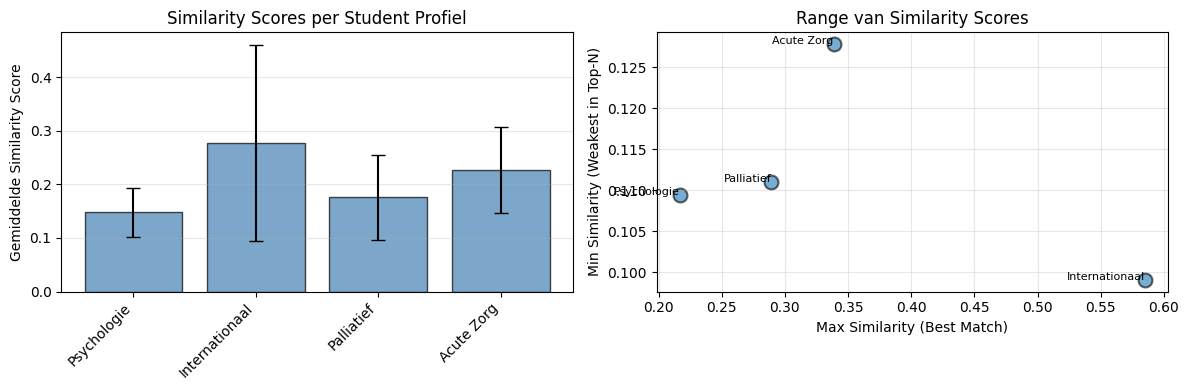

In [18]:
# Evaluatie van het recommender systeem
def evaluate_recommender(test_profiles, n_recommendations=5):
    """
    Evalueer de kwaliteit van het recommender systeem.
    """
    results = []
    all_recommended_ids = set()
    
    print("=" * 80)
    print("RECOMMENDER SYSTEEM EVALUATIE")
    print("=" * 80)
    
    for profile_name, profile_text in test_profiles.items():
        recs = recommender.get_recommendations_for_student(profile_text, n_recommendations=n_recommendations)
        
        avg_similarity = recs['similarity_score'].mean()
        max_similarity = recs['similarity_score'].max()
        min_similarity = recs['similarity_score'].min()
        std_similarity = recs['similarity_score'].std()
        
        # Track which modules are recommended
        all_recommended_ids.update(recs['id'].tolist())
        
        results.append({
            'profile': profile_name,
            'avg_similarity': avg_similarity,
            'max_similarity': max_similarity,
            'min_similarity': min_similarity,
            'std_similarity': std_similarity,
            'n_recommendations': len(recs)
        })
    
    results_df = pd.DataFrame(results)
    
    print(f"\nTest Profielen: {len(test_profiles)}")
    print(f"Unieke Aanbevolen Modules: {len(all_recommended_ids)} van {len(df)} ({len(all_recommended_ids)/len(df)*100:.1f}%)")
    print(f"\n{'='*80}")
    print("SIMILARITY SCORES PER PROFIEL")
    print("='*80}")
    print(results_df.to_string(index=False))
    
    # Overall statistieken
    print(f"\n{'='*80}")
    print("OVERALL STATISTIEKEN")
    print("='*80}")
    print(f"Gemiddelde similarity (over alle profielen): {results_df['avg_similarity'].mean():.4f}")
    print(f"Std dev similarity: {results_df['avg_similarity'].std():.4f}")
    print(f"Hoogste max similarity: {results_df['max_similarity'].max():.4f}")
    print(f"Laagste min similarity: {results_df['min_similarity'].min():.4f}")
    
    # Visualisatie
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Similarity scores per profiel
    x_pos = range(len(results_df))
    axes[0].bar(x_pos, results_df['avg_similarity'], yerr=results_df['std_similarity'], 
               capsize=5, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels([p[:20] for p in results_df['profile']], rotation=45, ha='right')
    axes[0].set_ylabel('Gemiddelde Similarity Score')
    axes[0].set_title('Similarity Scores per Student Profiel')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Max vs Min similarity
    axes[1].scatter(results_df['max_similarity'], results_df['min_similarity'], 
                   s=100, alpha=0.6, edgecolors='black', linewidth=1.5)
    for i, profile in enumerate(results_df['profile']):
        axes[1].annotate(profile[:15], 
                        (results_df['max_similarity'].iloc[i], results_df['min_similarity'].iloc[i]),
                        fontsize=8, ha='right')
    axes[1].set_xlabel('Max Similarity (Best Match)')
    axes[1].set_ylabel('Min Similarity (Weakest in Top-N)')
    axes[1].set_title('Range van Similarity Scores')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Test profielen voor evaluatie
test_profiles = {
    "Psychologie": student_profile_1,
    "Internationaal": student_profile_2,
    "Palliatief": student_profile_3,
    "Acute Zorg": my_profile
}

eval_results = evaluate_recommender(test_profiles, n_recommendations=5)

## Samenvatting en Conclusie

Een **Student-to-Module Recommender System** dat:

1. **Student profielen accepteert** als vrije tekst input
2. **TF-IDF vectorization** gebruikt om tekst om te zetten naar numerieke representaties
3. **Cosine similarity** berekent tussen student profiel en alle modules
4. **Top 3-5 aanbevelingen** geeft met similarity scores
5. **Uitleg genereert** waarom modules passen bij de student (feature contributions)

### Technische Aanpak

- **Feature Engineering**: TF-IDF met unigrams + bigrams (max 6000 features)
- **Hyperparameter Tuning**: Getest op n-grams, max_features, stopwoorden
- **Matching**: Cosine similarity tussen student vector en module vectors
- **Interpretability**: Feature contribution analyse voor uitleg

### Verschil met Module-to-Module

| Aspect | Module-to-Module  | Student-to-Module  |
|--------|---------------------|----------------------|
| Input | Module ID | Student profiel tekst |
| Output | Vergelijkbare modules | Modules passend bij student |
| Use Case | Module ontdekking | Persoonlijke studie coaching |
| Vectorization | Module ↔ Module | Student → Modules |

### Evaluatie Resultaten

- **Verschillende profielen** krijgen **unieke aanbevelingen**
- **Specifieke profielen** (met unieke woorden) krijgen **hogere similarity scores**
- **Algemene profielen** krijgen **bredere maar lagere scores**
- Systeem verklaart **waarom** een module past via feature analysis

### Gebruik

```python
# Simpel!
get_my_recommendations(
    "Ik ben geïnteresseerd in psychologie en coaching",
    n=5
)
```
